# Лабораторная работа № 6. Обучение с подреплением

В этой лабораторной работе мы возвращаемся к задаче о тележке со стержнем и попробуем применить к ней алгоритмы обучения с подкреплением, чтобы автоматически найти стратегию управления тележкой (а не задавать ее в виде правил, как это делалось в лабораторной работе № 3).

В отличие от работы № 3, здесь будет использоваться оригинальное окружение `CartPole` из библиотеки `gymnasium`, в котором на тележку можно подать всего два типа воздействий (толкнуть влево или толкнуть вправо). Поэтому мы ожидаем, что получающиеся стратегии не будут так же хороши, как найденная нечеткая, однако в образовательных целях этого будет достаточно.

Реализуемые в данной работе алгоритмы основаны на линейной аппроксимации функции ценности действия. То есть, функция ценности действия $\hat{q}(s, a)$ будет представлена как линейная функция от признаков, описывающих состояние системы. Для построения подобной линеаризации используется популярная техника - грубое кодирование, а именно, плиточное кодирование (tile coding). 


In [1]:
import random

import numpy as np

import gymnasium as gym

# 1. Загрузим окружение и проведем имитацию

In [2]:
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(500):
    action = env.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

Со случайным управлением стержень довольно часто падает. Воспользуемся функцией, похожей на ту, что мы использовали в  лабораторной работе 3, чтобы оценить количество падений стержня за заданное число шагов.

In [3]:
class RandomAgent:

    def get_action(self, obs):
        return 0 if random.random() < 0.5 else 1

def run(env, agent, n=10000):
    """Запускает имитацию заданного агента в заданном окружении.

    Имитация продолжается в `n` шагов. При падении стержня - перезапускается.
    Результатом работы является количество падений и временной ряд абсолютных
    отклонений стержня от вертикали (в градусах)."""

    fell = 0
    
    observation, info = env.reset()
    
    for _ in range(n):
        action = agent.get_action(observation) # env.action_space.sample()  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
    
        if terminated or truncated:
            observation, info = env.reset()
            fell += 1

    return fell

In [4]:
for agent_name, agent in [('Random agent', RandomAgent())]:
    env = gym.make("CartPole-v1")
    n_fell = run(env, agent, 10000)
    env.close()
    print(f'{agent_name}: {n_fell} падений')

Random agent: 440 падений


# 2. Плиточное кодирование (tile coding)

Суть плиточного кодирования заключается в том, чтобы разбить область допустимых значений непрерывного признака или набора признаков на прямоугольные ячейки, каждая из которых будет соответствовать одному признаку новой модели. Значение этого признака будет равно 1, если точка попадает внутрь ячейки и 0, если не попадает. Если на область допустимых значений наложить только одну такую сетку, то это будет, строго говоря, еще не плиточное кодирование, а только агрегация. При плиточном кодировании на область допустимых значений накладывается несколько таких сеток, границы которых не совпадают, в результате новое признаковое представление обладает определенным обобщением. 


In [5]:
class TileCoder2d:
    """Плиточное кодирование двух признаков."""
    
    def __init__(self, left, step, right, n_tilings):
        """Конструктор.
        
        left : numpy.array
            Левая (меньшая) граница области кодируемых значений,
            shape (2, )
        step : numpy.array
            Шаг сетки по каждому из признаков,
            shape (2, )
        right : numpy.array
            Правая (большая) граница области кодируемых значений,
            shape (2, )
        n_tilings : int
            Количество "сеток".
        """
        self.left = left
        self.step = step
        self.right = right
        # Количество клеток
        self.cells = np.ceil((self.right - self.left) / self.step).astype(int)
        self.n_tilings = n_tilings
        # Считаем, что сетки идут с равным шагом
        self.tile_shift = self.step / n_tilings
        # Количество признаков на одну сетку
        self.features_per_tiling = (self.cells[0] * self.cells[1]).astype(int)
        
    def _base_idx(self, tiling_id : int):
        """Базовый индекс набора признаков, соответствующих заданной
        сетке, во всем выходном пространстве признаков."""
        return self.features_per_tiling * tiling_id
    
    def _coord_to_idx(self, x, tile_id):
        # Нижняя граница для заданной сетки
        left = self.left + self.tile_shift * tile_id
        # Если заданное значение ниже границы, то заменяем
        # его нижней границей
        x = np.maximum(left, x)
        idxs = ((x - left) / self.step).astype(int)
        # Если значение было выше диапазона, то нужно убедиться,
        # что индекс ячейки будет допустимым
        idxs = np.minimum(idxs, self.cells - 1)
        return self.cells[1] * idxs[0] + idxs[1]
    
    def __call__(self, x):
        idxs = [self._base_idx(i) + self._coord_to_idx(x, i) for i in range(self.n_tilings)]
        v = np.zeros((self.n_features(), 1))
        v[idxs] = 1
        return v
    
    def n_features(self):
        return self.features_per_tiling * self.n_tilings


coder = TileCoder2d(np.array([-1., -1.]),  # нижняя граница
                    np.array([.5, .5]),  # шаг
                    np.array([1., 1.]),  # верхняя граница
                    2)
assert coder(np.array([-1., -1.])).sum() == 2
assert coder(np.array([1., 1.])).sum() == 2
assert np.all(coder(np.array([-1., -1.])) == coder(np.array([-0.9, -0.9])))
assert np.all(coder(np.array([1., -1.])) == coder(np.array([0.9, -0.9])))
# Вне сетки
assert coder(np.array([10., 10.])).sum() == 2
assert coder(np.array([-10., -10.])).sum() == 2

# 3. Алгоритм Sarsa

Этот алгоритм относится к классу алгоритмов, основанных на временных различиях (TD). Его название образовано от обозначения элементов последовательности, получаемой в ходе работы агента: S, A, R, S, A, ... На каждом шаге обрабатывается пять таких элементов - алгоритм пытается скорректировать оценку функции ценности $\hat{q}(s, a)$ для выбора состояния и управления на прошлом шаге ($s$ и $a$) с учетом полученного вознаграждения и текущей оценки для нового состояния ($s'$) и управления ($a'$). При использовании полуградиентной разновидности, работающей с аппроксимацией функции ценности, правило корректировки на каждом шаге выглядит так:

$$
w_{t+1} = w_t + \alpha[R + \gamma \hat{q}(s', a'; w)]\nabla\hat{q}(s, a; w). 
$$

В случае использования линейной аппроксимации (т.е. $\hat{q}(s, a; w) = w^T x(s)$) $\nabla\hat{q}(s, a; w)$ превращается просто в $x(s)$:

$$
w_{t+1} = w_t + \alpha[R + \gamma \hat{q}(s', a'; w)] x(s). 
$$
 

In [6]:
class CartPoleSarsaAgent:
    
    def __init__(self, gamma, alpha=0.1, epsilon=0.1):
        # Константа обучения, используемая в уравнении
        # уточнения оценки ценности действия
        self.alpha = alpha
        # Параметр эпсилон-жадной стратегии исследования
        self.epsilon = epsilon
        # Коэффициент дисконтирования
        self.gamma = gamma
        self.last_observation = None
        self.last_action = None
        # Плиточное кодирование параметров окружения
        # Первое значение касается угла, второе - угловой скорости
        self.tile_coder = TileCoder2d(np.array((-0.3, -3.0)), #
                                      np.array((0.02, 0.3)),
                                      np.array((0.3, 3.0)), 5)
        # Параметры аппроксимации
        # Первый столбец - для действия "налево",
        # второй столбец - для действия "направо"
        self.w = np.zeros((self.tile_coder.n_features(), 2), dtype=np.float32)

    def _strip_observation(self, observation):
        """Сохраняет только нужные компоненты среды."""
        x, v_x, angle, v_angle = observation
        return np.array([angle, v_angle])
        
    def get_action(self, observation):
        """Выбор действия без обучения.
        
        Нужно, в основном, для совместимости с другими
        видами агентов (например, из третьей лабораторной работы).
        """
        observation = self._strip_observation(observation)
        # Вычислим оценки стоимости действий
        q = self.get_q(observation)
        # Выберем наилучшее
        return np.argmax(q)
        
    def get_q(self, x):
        """Вычисление оценки стоимости действий (q(s, a))."""
        return np.dot(self.w.T, self.tile_coder(x)) 
        
    def learn_action_first(self, observation):
        """Выбор первого действия в сценарии.
        
        Эта функция отличается от просто `learn_action`,
        потому что при выборе первого действия еще нет
        требуемой алгоритму Sarsa пятерки S, A, R, S, A.
        """
        observation = self._strip_observation(observation)
        # Запоминаем состояние
        self.last_observation = observation
        # И выбираем действие случайным образом
        self.last_action = 0 if np.random.random() < 0.5 else 1
        return self.last_action
    
    def learn_action(self, reward, observation, last):
        """Основная функция, где происходит кооректировка оценки 
        и выбор действия."""
        observation = self._strip_observation(observation)
        # Выбираем очередное действие в соответствии с 
        # эпсилон-жадной стратегией
        q = self.get_q(observation)
        if np.random.random() < self.epsilon:
            action = 0 if np.random.random() < 0.5 else 1
        else:
            action = np.argmax(q)
        
        # Получим признаковое представление и оценку для последнего
        # состояния
        prev_x = self.tile_coder(self.last_observation)
        prev_estimate = self.get_q(self.last_observation)
        
        # Логика последнего шага эпизода немного отличается - 
        # действие нам выбирать уже не надо, стержень уже упал,
        # поэтому TD-целью для предыдущего состояния является просто
        # последнее полученное вознаграждение
        if last:
            self.w[:, self.last_action] = self.w[:, self.last_action] + \
                (self.alpha * (reward - prev_estimate[self.last_action]) * prev_x).ravel()
            self.last_observation = None
            self.last_action = None            
        else:
            self.w[:, self.last_action] = self.w[:, self.last_action] + \
                (self.alpha * (reward + self.gamma * q[action] - prev_estimate[self.last_action]) * prev_x).ravel()
            self.last_observation = observation
            self.last_action = action
        
        return self.last_action



Обучим агента, для этого инициируем его взаимодействие со средой на протяжении большого количества шагов, при падении стержня просто перезапуская обучение:

In [7]:
agent = CartPoleSarsaAgent(0.8)

In [8]:
env = gym.make("CartPole-v1")
observation, info = env.reset(seed=42)
# В этот список будем собирать длину эпизодов
history = []
action = agent.learn_action_first(observation)
observation, reward, terminated, truncated, info = env.step(action)
start = 0
for step in range(100000):
    action = agent.learn_action(reward, observation, terminated or truncated)
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        history.append(step - start)
        start = step
        observation, info = env.reset()
        action = agent.learn_action_first(observation)        
        observation, reward, terminated, truncated, info = env.step(action)

env.close()

In [9]:
import matplotlib
import matplotlib.pyplot as plt

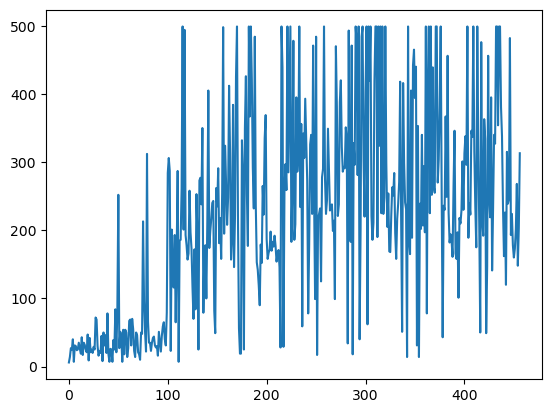

In [10]:
plt.plot(range(len(history)), history)

Видно, что в определенный момент длина эпизода увеличилась до 200, после чего осталась приблизительно на одном и том же уровне. Оценим стратегию визуально:

In [11]:
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()
for step in range(300):
    action = agent.get_action(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        observation, info = env.reset()
env.close()

Оценим качество стратегии численно:

In [12]:
for agent_name, agent in [('Sarsa agent', agent)]:
    env = gym.make("CartPole-v1")
    n_fell = run(env, agent, 10000)
    env.close()
    print(f'{agent_name}: {n_fell} падений')

Sarsa agent: 36 падений


Видно, что количество падений стержня существенно меньше, чем у необученной модели. Да и визуально управление выглядит вполне разумным, хотя и не без изъянов.

**Задания:**

1. У реализованного алгоритма есть несколько параметров: коэффициент дисконтирования, константа обучения, параметр $\epsilon$-жадной стратегии, параметры плиточного кодирования. Исследуйте влияние этих параметров на скорость обучения и характеристики найденной стратегии.
2. Что будет, если в ходе обучения постепенно изменять параметр $\epsilon$, приближая стратегию выбора действия к жадной.
3. На базе класса `CartPoleSarsaAgent` реализуйте агента, использующего алгоритм Q-обучения. Подсказка: для этого достаточно будет изменить две-три строчки. Исследуйте поведение этого агента.
4. (**не обязательно, +3 балла**). Одной из причин не особенно впечатляющего поведения реализованного выше агента является то, что он использует только два из параметров, описывающих систему (пусть и самые информативные), из-за чего ему "тяжело" идентифицировать ситуацию скольжения тележки и выезда ее за пределы допустимой области, что также вызывает прерывание эпизода. Добавьте в модель признаки, соответствующие положению тележки. Для этого, например, можно расширить плиточное кодирование на третье измерение.